In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%matplotlib inline

In [83]:
def maxnormed_bar(u,normed=True,**kwargs):
    vs, bs = np.histogram(u, bins=kwargs.get('bins',10))
    if normed:
        vs = vs / vs.max()
    kwargs.pop('bins')
    
    plt.bar(bs[:-1], vs, align='edge', width=bs[1]-bs[0], **kwargs)

def maxnormed_step(u,normed=True,**kwargs):
    vs, bs = np.histogram(u, bins=kwargs.get('bins',10))
    if normed:
        vs = vs / vs.max()
    kwargs.pop('bins')
    
    plt.step(bs[:-1], vs, where='post', **kwargs)

## Gradients 

In [179]:
T = 1024
N = 1024
L = 10

In [360]:
# vanilla
x = torch.randn(T,N,requires_grad=True).cuda() / np.sqrt(2)
x.retain_grad()
xs_vn, ys_vn, zs_vn = [x], [], []

for l in range(L):
    # forward
    W = torch.randn(N,N).cuda() / np.sqrt(N/2)
    y = x.mm(W)
    z = y
    x = z.relu()
    
    # retain grads
    y.retain_grad()
    x.retain_grad()
    z.retain_grad()
    
    # retain reference
    ys_vn.append(y)
    zs_vn.append(z)
    xs_vn.append(x)
    
    
# backward
# e = (torch.randn_like(x) * x).sum()
e = (torch.randn_like(x[:1]) * x).sum()
e.backward()

In [181]:
# batchnorm 
x = torch.randn(T,N,requires_grad=True).cuda() / np.sqrt(2)
x.retain_grad()
xs_bn, ys_bn, zs_bn = [x], [], []

for l in range(L):
    # forward
    W = torch.randn(N,N).cuda() / np.sqrt(N/2)
    y = x.mm(W)
    z = (y - y.mean(dim=0,keepdim=True) ) / y.std(dim=0,keepdim=True)
    x = z.relu()
    
    # retain grads
    y.retain_grad()
    x.retain_grad()
    z.retain_grad()
    
    # retain reference
    ys_bn.append(y)
    zs_bn.append(z)
    xs_bn.append(x)
    
    
# backward
# e = (torch.randn_like(x) * x).sum()
e = (torch.randn_like(x[:1]) * x).sum()
e.backward()

In [216]:
# batchnorm 
x = torch.randn(T,N,requires_grad=True).cuda() / np.sqrt(2)
x.retain_grad()
xs_fn, ys_fn, zs_fn = [x], [], []

for l in range(L):
    # forward
    W = torch.randn(N,N).cuda() / np.sqrt(N/2)
    y = x.mm(W)
    z = (y - y.mean(dim=0,keepdim=True).detach() ) / y.std(dim=0,keepdim=True).detach()
    x = z.relu()
    
    # retain grads
    y.retain_grad()
    x.retain_grad()
    z.retain_grad()
    
    # retain reference
    ys_fn.append(y)
    zs_fn.append(z)
    xs_fn.append(x)
    
    
# backward
# e = (torch.randn_like(x) * x).sum()
e = (torch.randn_like(x[:1]) * x).sum()
e.backward()

## Grad Norms 

1.0037648768895822
1.2140164962656896
1.2122325492533372


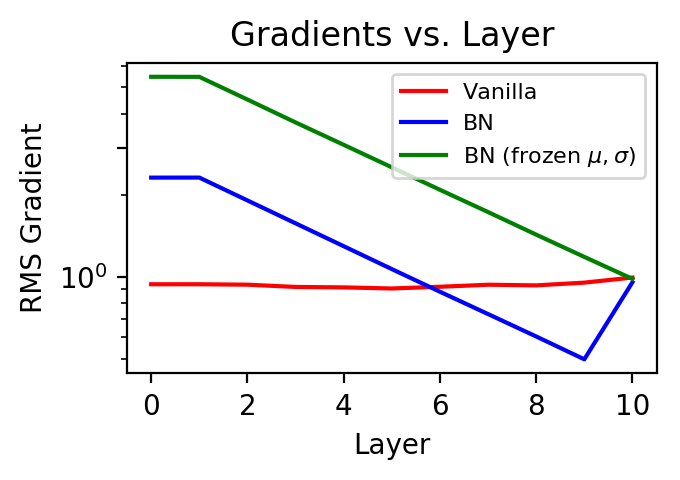

In [371]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(3.5,2.5), dpi=200)

gxs_vn = [(x.grad**2).mean().sqrt().item() for x in xs_vn]
gxs_bn = [(x.grad**2).mean().sqrt().item() for x in xs_bn]
gxs_fn = [(x.grad**2).mean().sqrt().item() for x in xs_fn]

plt.plot(gxs_vn, color='red', label='Vanilla')
plt.plot(gxs_bn, color='blue', label='BN')
plt.plot(gxs_fn, color='green', label=r'BN (frozen $\mu,\sigma$)')

plt.yscale('log')

plt.legend(fontsize=legend_fontsize)
plt.xlabel('Layer', fontsize=axlabel_fontsize)
plt.ylabel('RMS Gradient', fontsize=axlabel_fontsize)
plt.title('Gradients vs. Layer', fontsize=title_fontsize)

plt.yticks([1,3])
import matplotlib
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.tight_layout()
plt.savefig('hist_widths.png')

print(gxs_vn[1] / gxs_vn[2])
print(gxs_bn[1] / gxs_bn[2])
print(gxs_fn[1] / gxs_fn[2])

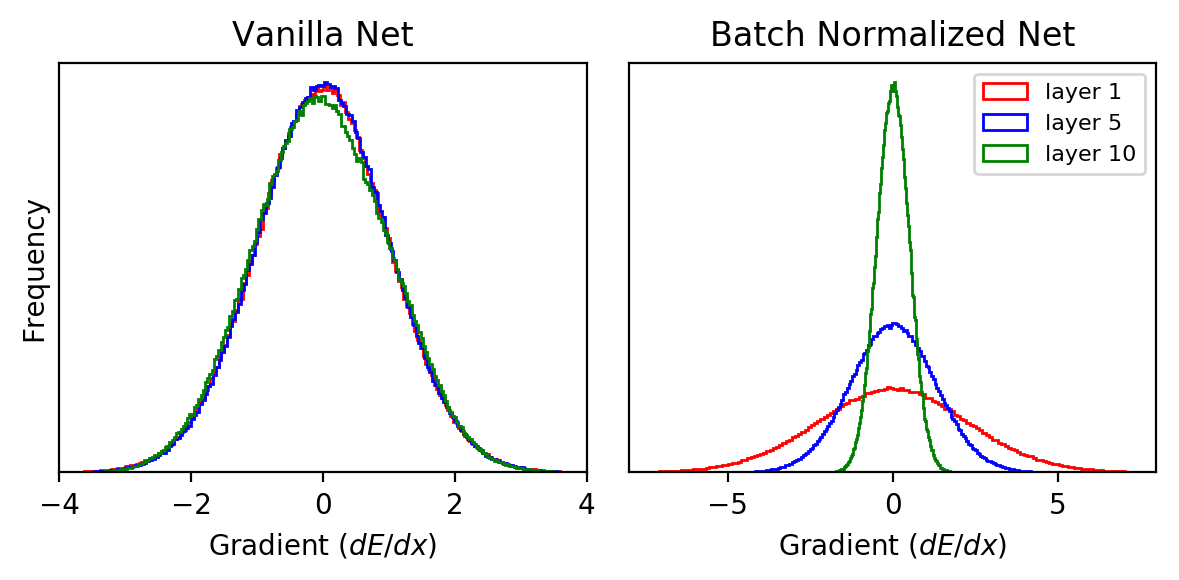

In [197]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(121)
plt.hist(xs_vn[0].grad.cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_vn[4].grad.cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_vn[9].grad.cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-4.0,+4.0)

plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.ylabel('Frequency', fontsize=axlabel_fontsize)
plt.yticks([])
plt.title('Vanilla Net', fontsize=title_fontsize)

plt.subplot(122)
plt.hist(xs_bn[0].grad.cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[4].grad.cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[9].grad.cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

# plt.xlim(-400,+400)
plt.xlim(-20, +20)
plt.xlim(-8, +8)

plt.legend(fontsize=legend_fontsize)
plt.yticks([])
plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.title('Batch Normalized Net', fontsize=title_fontsize)

plt.tight_layout()
# plt.savefig('../assets/bn_gradient_simulation.png')
plt.show()

In [211]:
xs_fn[9].grad.std(), xs_bn[9].grad.std()

(tensor(1.1903, device='cuda:0'), tensor(0.4972, device='cuda:0'))

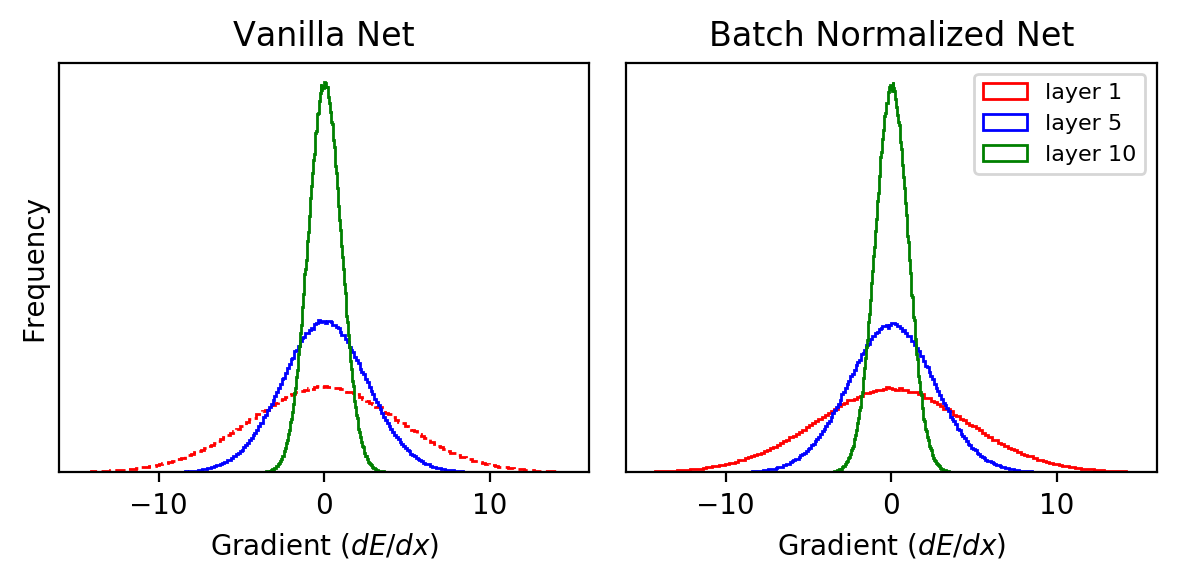

In [221]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(121)
n = xs_fn[9].grad.std().item()
plt.hist(xs_fn[0].grad.cpu().flatten()/n, label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_fn[4].grad.cpu().flatten()/n, label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_fn[9].grad.cpu().flatten()/n, label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-16, +16)

plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.ylabel('Frequency', fontsize=axlabel_fontsize)
plt.yticks([])
plt.title('Vanilla Net', fontsize=title_fontsize)

plt.subplot(122)
n = xs_bn[9].grad.std().item()
plt.hist(xs_bn[0].grad.cpu().flatten()/n, label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[4].grad.cpu().flatten()/n, label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[9].grad.cpu().flatten()/n, label='layer 10', color='green', histtype='step', bins=bins, normed=True)

# plt.xlim(-400,+400)
plt.xlim(-20, +20)
plt.xlim(-16, +16)

plt.legend(fontsize=legend_fontsize)
plt.yticks([])
plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.title('Batch Normalized Net', fontsize=title_fontsize)

plt.tight_layout()
# plt.savefig('../assets/bn_gradient_simulation.png')
plt.show()

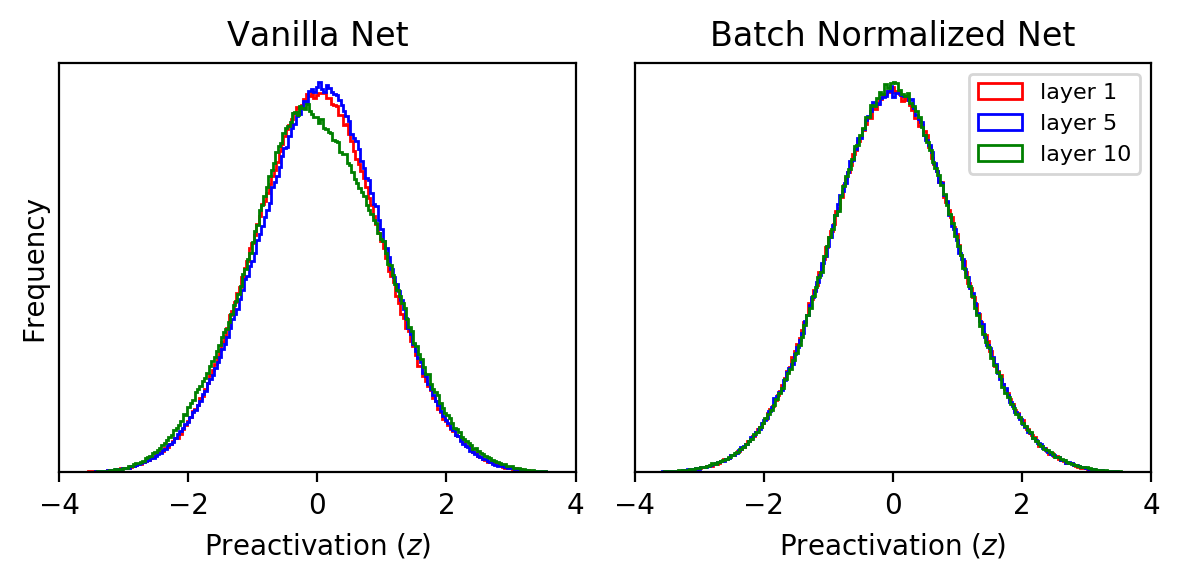

In [173]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(121)
plt.hist(zs_vn[0].detach().cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(zs_vn[4].detach().cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(zs_vn[9].detach().cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-4.0,+4.0)

plt.xlabel(r'Preactivation ($z$)', fontsize=axlabel_fontsize)
plt.ylabel('Frequency', fontsize=axlabel_fontsize)
plt.yticks([])
plt.title('Vanilla Net', fontsize=title_fontsize)

plt.subplot(122)
plt.hist(zs_bn[0].detach().cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(zs_bn[4].detach().cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(zs_bn[9].detach().cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-4.0,+4.0)

plt.legend(fontsize=legend_fontsize)
plt.yticks([])
plt.xlabel(r'Preactivation ($z$)', fontsize=axlabel_fontsize)
plt.title('Batch Normalized Net', fontsize=title_fontsize)

plt.tight_layout()
plt.savefig('../assets/bn_preactivations.png')
plt.show()

## Justifying small average assumptions 

In [244]:
dzmean_bn = [z.grad.mean(dim=1) for z in zs_bn]
zdzmean_bn = [(z*z.grad).mean(dim=1) for z in zs_bn]
dzstd_bn = [z.grad.std(dim=1) for z in zs_bn]

In [247]:
dzmean_bn[0]

tensor([-0.0357, -0.0857,  0.0214,  ...,  0.0577,  0.0293,  0.0386],
       device='cuda:0')

In [248]:
zdzmean_bn[0]

tensor([-0.0616, -0.0673,  0.0466,  ...,  0.1032,  0.0395, -0.0092],
       device='cuda:0', grad_fn=<MeanBackward0>)

In [249]:
dzstd_bn[0]

tensor([1.7721, 1.7503, 1.3235,  ..., 1.7583, 1.2782, 1.5696], device='cuda:0')

## Activity Distributions

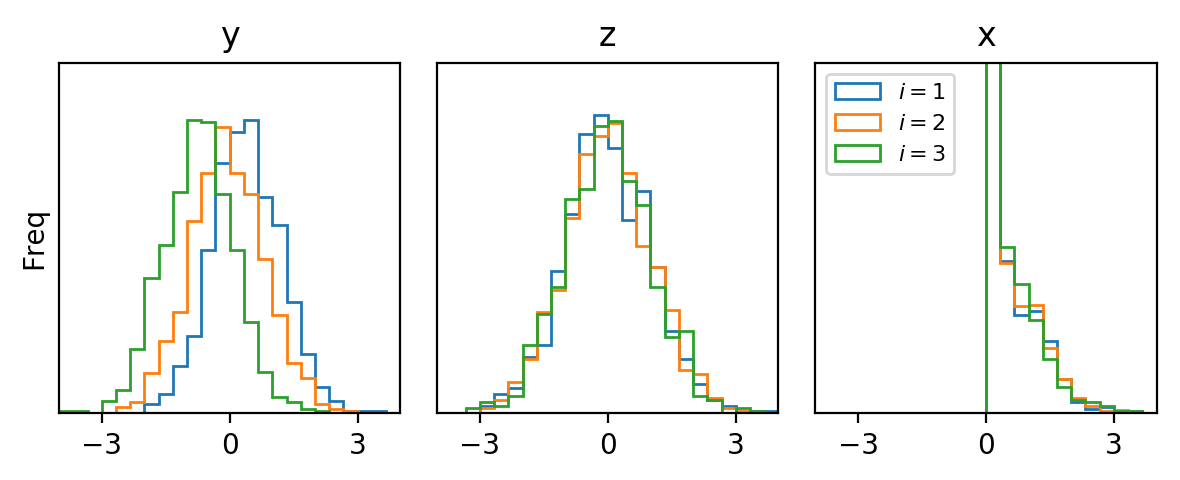

In [317]:
xs_vn = [u for u in xs_bn]
ys_bn = [u for u in ys_bn]
zs_bn = [u for u in zs_bn]

bins = np.linspace(-4.0, 4.0, 25)

title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,2.5), dpi=200)
plt.subplot(131)
plt.hist(ys_bn[4][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(ys_bn[4][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(ys_bn[4][:,4].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.6)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])

plt.ylabel('Freq')

plt.title('y')

plt.subplot(132)
plt.hist(zs_bn[4][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_bn[4][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_bn[4][:,2].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])


plt.title('z')

plt.subplot(133)
plt.hist(xs_bn[4][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(xs_bn[4][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(xs_bn[4][:,2].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.8)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])

plt.legend(fontsize=legend_fontsize, loc='upper left')

plt.title('x')

plt.tight_layout()

plt.show()


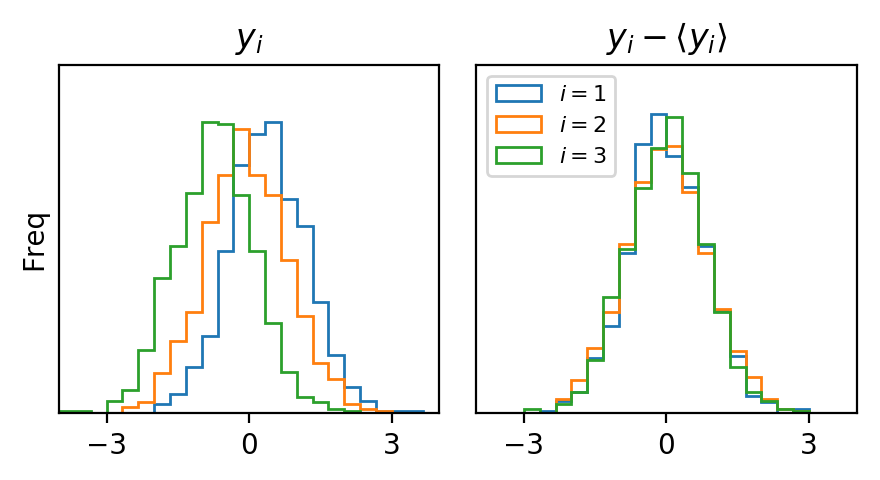

In [324]:
xs_vn = [u for u in xs_bn]
ys_bn = [u for u in ys_bn]
zs_bn = [u for u in zs_bn]

bins = np.linspace(-4.0, 4.0, 25)

title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(4.5,2.5), dpi=200)
plt.subplot(121)
plt.hist(ys_bn[4][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(ys_bn[4][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(ys_bn[4][:,4].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.6)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])
plt.ylabel('Freq')

plt.title(r'$y_i$')

plt.subplot(122)
plt.hist((ys_bn[4][:,0]-ys_bn[4].mean(0)[0]).detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist((ys_bn[4][:,1]-ys_bn[4].mean(0)[1]).detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist((ys_bn[4][:,4]-ys_bn[4].mean(0)[4]).detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.6)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])
plt.legend(fontsize=legend_fontsize, loc='upper left')

plt.title(r'$y_i-\langle y_i \rangle$')


plt.tight_layout()

plt.show()


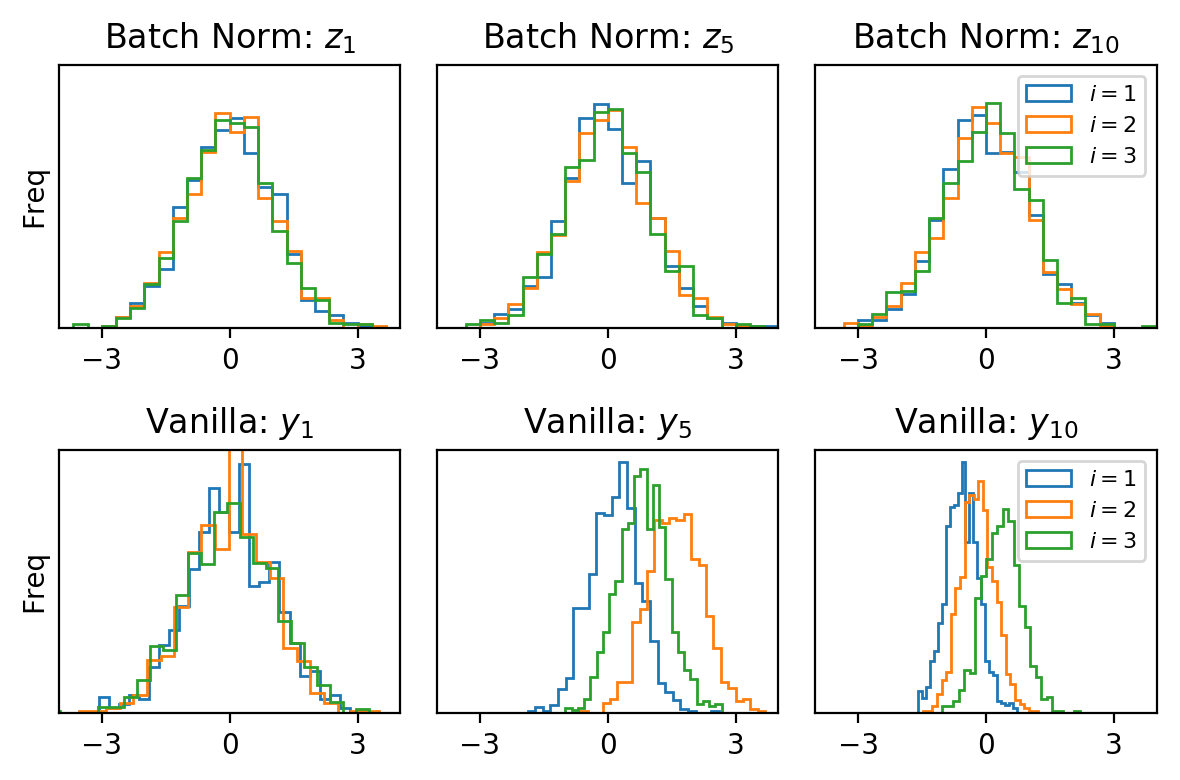

In [357]:
xs_vn = [u for u in xs_bn]
ys_bn = [u for u in ys_bn]
zs_bn = [u for u in zs_bn]

bins = np.linspace(-4.0, 4.0, 25)

title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,4), dpi=200)
##############
# Batch Norm #
##############

plt.subplot(231)
plt.hist(zs_bn[0][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_bn[0][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_bn[0][:,4].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])

plt.ylabel('Freq')

plt.title(r'Batch Norm: $z_{1}$')

plt.subplot(232)
plt.hist(zs_bn[4][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_bn[4][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_bn[4][:,2].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])


plt.title(r'Batch Norm: $z_{5}$')

plt.subplot(233)
plt.hist(zs_bn[9][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_bn[9][:,1].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_bn[9][:,2].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])

plt.title(r'Batch Norm: $z_{10}$')


plt.legend(fontsize=legend_fontsize, loc='upper right')

##############
# Vanilla    #
##############
bins = 25
plt.subplot(234)
plt.hist(zs_vn[0][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_vn[0][:,5].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_vn[0][:,3].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])

plt.ylabel('Freq')

plt.title(r'Vanilla: $y_{1}$')

plt.subplot(235)
plt.hist(zs_vn[4][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_vn[4][:,5].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_vn[4][:,3].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
# plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])


plt.title(r'Vanilla: $y_{5}$')

plt.subplot(236)
plt.hist(zs_vn[9][:,0].detach().cpu(), bins=bins, histtype='step', label=r'$i=1$', normed=True)
plt.hist(zs_vn[9][:,5].detach().cpu(), bins=bins, histtype='step', label=r'$i=2$', normed=True)
plt.hist(zs_vn[9][:,3].detach().cpu(), bins=bins, histtype='step', label=r'$i=3$', normed=True)

plt.xlim(-4, 4)
# plt.ylim(0, 0.5)
plt.xticks([-3.0, 0.0, 3.0])
plt.yticks([])

plt.legend(fontsize=legend_fontsize, loc='upper right')

plt.title(r'Vanilla: $y_{10}$')


plt.tight_layout()

plt.show()


## Grad Distributions

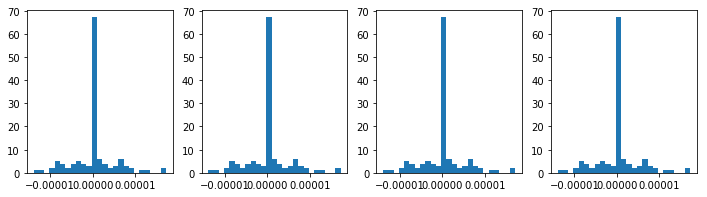

In [49]:
gzs_vn = [z.grad for x in xs_vn]
gzs_bn = [z.grad for x in xs_bn]

plt.figure(figsize=(12,3))
plt.subplot(141)
plt.hist(gzs_vn[0][:,0].cpu(), bins=25)

plt.subplot(142)
plt.hist(gzs_vn[4][:,0].cpu(), bins=25)

plt.subplot(143)
plt.hist(gzs_vn[9][:,0].cpu(), bins=25)

plt.subplot(144)
plt.hist(gzs_vn[24][:,0].cpu(), bins=25)
plt.show()
